In [1]:
%%time
%matplotlib inline

import importlib
import new_import_ODC  

importlib.reload(new_import_ODC)

from new_import_ODC import *

CPU times: user 13.3 s, sys: 4.16 s, total: 17.5 s
Wall time: 11.1 s


In [2]:
%%time
# Cấu hình Daskgateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1, 10))
# Khai báo 1 Datacube là dc
dc = datacube.Datacube()

# Cấu hình truy cập dịch vụ S3
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

client

Starting new cluster.
CPU times: user 796 ms, sys: 23 ms, total: 819 ms
Wall time: 3min 50s


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.f784f9716940470ba373a5ed5748586f/status,


In [3]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ("2022-09-01", "2023-10-01")
date_range1 = ("2024-01-01", "2024-05-01")
longtitude_range = (105.5, 106.4)
latitude_range = (9.2, 10.0)

coordinates = (longtitude_range, latitude_range)

In [4]:
## truy vấn ảnh vệ tinh sen2
data = load_data(dc, date_range, longtitude_range, latitude_range)
notebook_utils.heading(notebook_utils.xarray_object_size(data))
display(data)

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 151, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [5]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_clean(data)
progress(result)

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 2.35 s, sys: 67.6 ms, total: 2.42 s
Wall time: 2.42 s


VBox()

In [6]:
# Tiến hành tính toán NDVI
ds1 = calculate_indices(result, index="NDVI", satellite_mission="s2")
ndvi = ds1["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 151, y: 8874, x: 9902)>
dask.array<truediv, shape=(151, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648

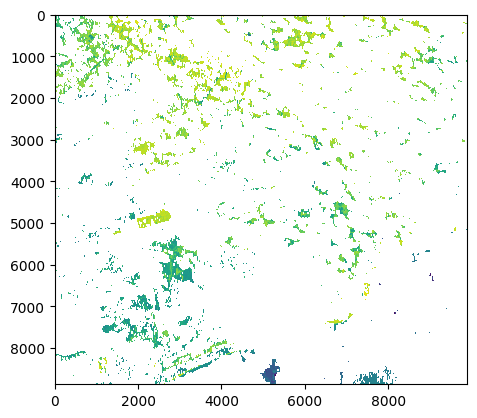

In [7]:
## ảnh ndvi chưa fill nan
plt.imshow(ndvi.isel(time=6))

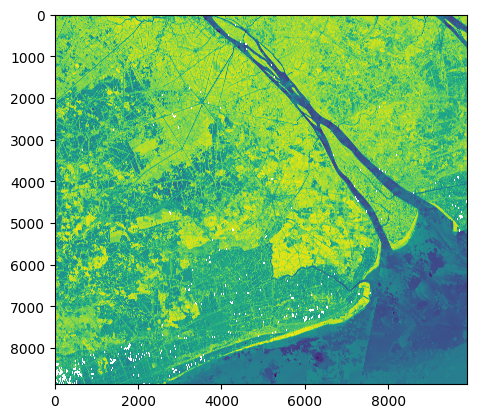

In [8]:
# đặt thời gian các mùa
time_split = [
    slice("2022-09-01", "2023-01-01"),
    slice("2023-01-01", "2023-05-01"),
    slice("2023-05-01", "2023-07-01"),
    slice("2023-07-01", "2023-10-01"),
]

# fill nan
fill_nan_ndvi = fill_nan(ndvi, time_split)

## ảnh ndivi đã fill nan
plt.imshow(fill_nan_ndvi.isel(time=0))

In [9]:
%%time
## tính ndvi theo tháng
average_ndvi = fill_nan_ndvi.resample(time="1M").mean().persist()
progress(average_ndvi)

# compute average_ndvi
average_ndvi = average_ndvi.compute()

CPU times: user 6.65 s, sys: 2.85 s, total: 9.49 s
Wall time: 1min 43s


In [10]:
#Load dữ liệu ảnh Sentinel 1
dsvh, dsvv = load_data_sen1_test_10m(dc, date_range1, coordinates)
average_vv = calculate_average(dsvv, time_pattern='1M')
average_vh = calculate_average(dsvh, time_pattern='1M')

<xarray.Dataset>
Dimensions:      (time: 20, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2024-01-07T11:03:51.500000 ... 2024-04...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [11]:
## cấu hình dữ liệu train và vh vv file
train_path = "train/ST_training data_updated_1130points.shp"  # đường dẫn shp file train

## load dữ liệu điểm train
train = load_train_data(train_path)
train.head()

# cấu hình nhãn dữ liệu
label_mapping = {
    "Lua tom": "0",
    "Lua": "1",
    "CHN": "2",
    "CLN": "3",
    "TS": "4",
    "Song": "5",
    "Dat xay dung": "6",
    "Rung": "7",
}

# xây dựng tập dataset
datasets = get_data_sen1_and_sen2(train, average_ndvi, average_vh, average_vv)

# chia tập dữ liệu train, val, test
X_train, X_val, X_test, y_train, y_val, y_test = split_train_data(
    train, label_mapping, datasets
)

In [12]:
# Huấn luyện mô hình
grid_search = train_with_rf(X_train, X_val, y_train, y_val)

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 300}
Accuracy: 78.0 %


In [13]:
# kiểm tra độ chính xác với tập test
y_pred_test = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy for test data {round(test_accuracy, 2)*100} %")

Accuracy for test data 82.0 %


In [14]:
# Lưu mô hình huấn luyện
save_model("model_odc.joblib", grid_search)

Done!


In [15]:
# đóng client, cluster
client.close()
cluster.close()